### Imports

In [2]:
import operator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import feature_selection
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from IPython.core.pylabtools import figsize 
%matplotlib inline

### Aux Functions

In [3]:
class ItemSelector(BaseEstimator, TransformerMixin):
    """For data grouped by feature, select subset of data at a provided key.

    The data is expected to be stored in a 2D data structure, where the first
    index is over features and the second is over samples.  i.e.

    >> len(data[key]) == n_samples

    Please note that this is the opposite convention to scikit-learn feature
    matrixes (where the first index corresponds to sample).

    ItemSelector only requires that the collection implement getitem
    (data[key]).  Examples include: a dict of lists, 2D numpy array, Pandas
    DataFrame, numpy record array, etc.

    >> data = {'a': [1, 5, 2, 5, 2, 8],
               'b': [9, 4, 1, 4, 1, 3]}
    >> ds = ItemSelector(key='a')
    >> data['a'] == ds.transform(data)

    ItemSelector is not designed to handle data grouped by sample.  (e.g. a
    list of dicts).  If your data is structured this way, consider a
    transformer along the lines of `sklearn.feature_extraction.DictVectorizer`.

    Parameters
    ----------
    key : hashable, required
        The key corresponding to the desired value in a mappable.
    """
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]

### Analysis

In [4]:
# varq = pd.read_csv("../data/processed/properties-varq.tab.gz", sep="\t", index_col="MUTANT")
# varq = pd.read_csv("../data/processed/humsavar_varq_gt.csv.gz", sep=",", index_col="MUTANT").drop("dbSNP", 1)
varq = pd.read_csv("../data/processed/varq/varq_clean.csv.gz", index_col="MUTANT")
varq = varq[varq.TYPE != "Unclassified"].drop("ACTIVE_SITE", 1)

In [5]:
varq.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY', 'TYPE'],
      dtype='object')

In [6]:
varq.index.unique().shape

(7418,)

In [7]:
print("Size: \n", varq.shape)
print("\nValue counts of TYPE: \n", varq.TYPE.value_counts())

Size: 
 (7418, 10)

Value counts of TYPE: 
 Pathogenic    5377
Benign        2041
Name: TYPE, dtype: int64


In [8]:
varq.describe()

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
count,7070.000000,7070.000000,7070.000000,6704.000000,5335.000000,2742.000000,7418.000000
mean,32.105675,0.150610,56.445569,0.384835,5.017957,0.330460,2.914977
std,39.148405,0.176877,71.760154,0.890387,17.607171,0.188785,4.842729
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.130000,-12.642100
25%,0.670000,0.000000,19.765000,0.000000,0.000000,0.250000,0.257785
50%,15.208000,0.070000,37.342500,0.009150,0.000000,0.300000,1.512550
75%,52.149250,0.270000,61.138125,0.277000,0.163000,0.370000,3.885900
max,246.410000,0.750000,755.610000,8.720000,100.000000,4.770000,57.513400


In [9]:
corr = varq.drop(['3DID', 'PDB'], axis=1).corr()

In [10]:
corr

,SASA,SASA_PERCENTAGE,BFACTOR,SWITCHBILITY,AGGREGABILITY,CONSERVATION,VARIATION_ENERGY
SASA,1.000000,0.963621,0.079879,-0.038746,0.014785,0.016618,-0.349207
SASA_PERCENTAGE,0.963621,1.000000,0.112154,-0.044397,0.019902,0.028529,-0.373402
BFACTOR,0.079879,0.112154,1.000000,0.055923,0.151166,-0.026455,-0.081219
SWITCHBILITY,-0.038746,-0.044397,0.055923,1.000000,0.032105,0.025763,-0.030136
AGGREGABILITY,0.014785,0.019902,0.151166,0.032105,1.000000,-0.009340,-0.041672
CONSERVATION,0.016618,0.028529,-0.026455,0.025763,-0.009340,1.000000,-0.033151
VARIATION_ENERGY,-0.349207,-0.373402,-0.081219,-0.030136,-0.041672,-0.033151,1.000000


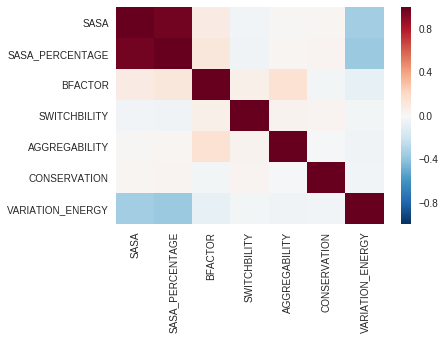

In [11]:
plot = sns.heatmap(corr)
figure = plot.get_figure()

### Machine Learning

In [12]:
# feature_union = 
cat_vars = ["PDB", "3DID"]
cont_vars = varq.columns[~varq.columns.isin(cat_vars + ["TYPE"])]

impute = ('union', 
          FeatureUnion(
              transformer_list=[
                  ('continuous', Pipeline([
                      ('selector', ItemSelector(key=cont_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="median"))
                  ])),
                  ('categorical', Pipeline([
                      ('selector', ItemSelector(key=cat_vars)),
                      ('imputer', Imputer(missing_values="NaN", strategy="most_frequent"))
                      
                  ]))
              ]))
                  


scale = ('scaler', RobustScaler())

model_dict = {
    'lr':{'pipe':[impute, scale, ('lr', LogisticRegression())],
        'params':[{'lr__C' : [.001, .01, .1, 1, 10, 100, 1000], 'lr__class_weight':[None, 'balanced']}],
        'name':'LogisticRegression'
    },
    'rf':{'pipe':[impute, ('rf', RandomForestClassifier(random_state = 100))],
        'params':[{'rf__max_depth':[3,5,7], 'rf__n_estimators':[10,50,100], 'rf__max_features':[4,'sqrt',0.2]}],
        'name':'Random Forest'
    },
    'svc':{'pipe': [impute, scale, ('svc', SVC(kernel='rbf'))],
           'params':[{'svc__kernel': ['rbf'], 'svc__gamma': [1e-2, 1e-3, 1e-4, 1e-5],
                'svc__C': [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]}]
        
    },
}

In [13]:
le = LabelEncoder()

X = varq[~varq.TYPE.isnull()].drop(['TYPE'], 1)

# .replace({"ACTIVE_SITE": {"BINDING": 1, np.nan: 0}})
y = le.fit_transform(varq[~varq.TYPE.isnull()].TYPE)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [14]:
y_test.shape

(2448,)

In [15]:
y_test.sum()

1774

#### Random Forest

In [16]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'rf'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [17]:
X_test.shape

(2448, 9)

In [18]:
pd.Series(y_test).value_counts()

1    1774
0     674
dtype: int64

In [19]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=2)]: Done  81 out of  81 | elapsed:    8.0s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7fbd6bc53728>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', 'VARIATION_ENERGY'],
      dtype='object'))), ('imputer...timators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'rf__max_depth': [3, 5, 7], 'rf__n_estimators': [10, 50, 100], 'rf__max_features': [4, 'sqrt', 0.2]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [20]:
rf = gs.best_estimator_

In [21]:
gs.best_score_

0.7371636735901945

In [22]:
model

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', 'VARIATION_ENERGY'],
      dtype='object'))), ('imputer...timators=10, n_jobs=1,
            oob_score=False, random_state=100, verbose=0, warm_start=False))])

In [23]:
X_train.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY'],
      dtype='object')

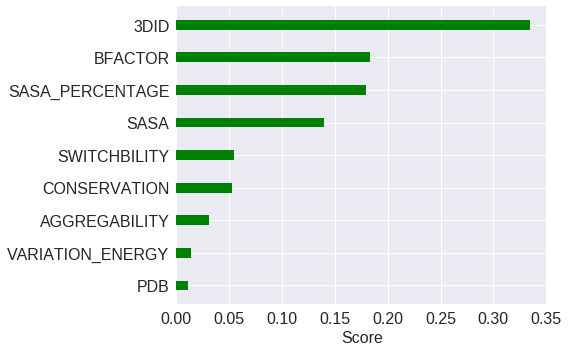

In [24]:
importances = [(X_train.columns[e], x) for e, x in enumerate(rf.steps[1][1].feature_importances_)]
importances.sort(key=operator.itemgetter(1), reverse=False)
figsize(8, 5)
# plt.title("Importancia", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], 0.3, color="g", align="center")
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
plt.xlabel("Score",fontsize=16)
plt.xticks(fontsize=16)
# plt.xlim([0, range(len(importances))])
# plt.show()
plt.tight_layout()

plt.savefig("importances_varq.pdf", bbox_inches='tight', pad_inches=0.1)


In [25]:
le.inverse_transform(y_test)

/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array(['Pathogenic', 'Pathogenic', 'Pathogenic', ..., 'Pathogenic',
       'Pathogenic', 'Pathogenic'], dtype=object)

In [26]:
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(rf.predict(X_test))))

             precision    recall  f1-score   support

     Benign       0.57      0.26      0.36       674
 Pathogenic       0.77      0.93      0.84      1774

avg / total       0.71      0.74      0.71      2448



/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/marlan/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [39]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [40]:
fpr.shape

(852,)

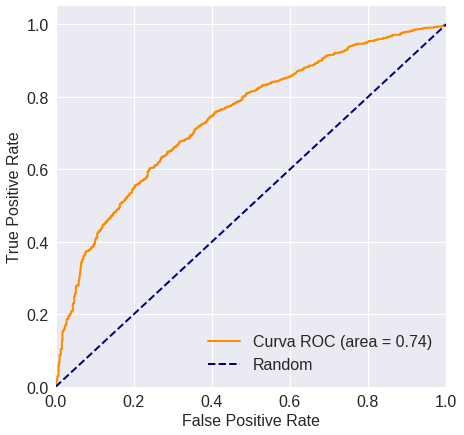

In [53]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='Curva ROC (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
# plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 16})

plt.savefig("auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

#### Logistic Regression

In [137]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'lr'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [138]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits


[Parallel(n_jobs=2)]: Done  42 out of  42 | elapsed:    0.8s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f6ea3cbabf8>,
       error_score='raise',
       estimator=Pipeline(steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(steps=[('selector', ItemSelector(key=Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', 'VARIATION_ENERGY'],
      dtype='object'))), ('imputer', Imputer(axis=0,...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=2,
       param_grid=[{'lr__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'lr__class_weight': [None, 'balanced']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [139]:
lr = gs.best_estimator_

In [140]:
gs.best_score_

0.7140964550085267

In [77]:
lr.steps[2]

('lr',
 LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False))

In [141]:
importances = list(zip(X_train.columns.tolist(), lr.steps[2][1].coef_[0].tolist()))

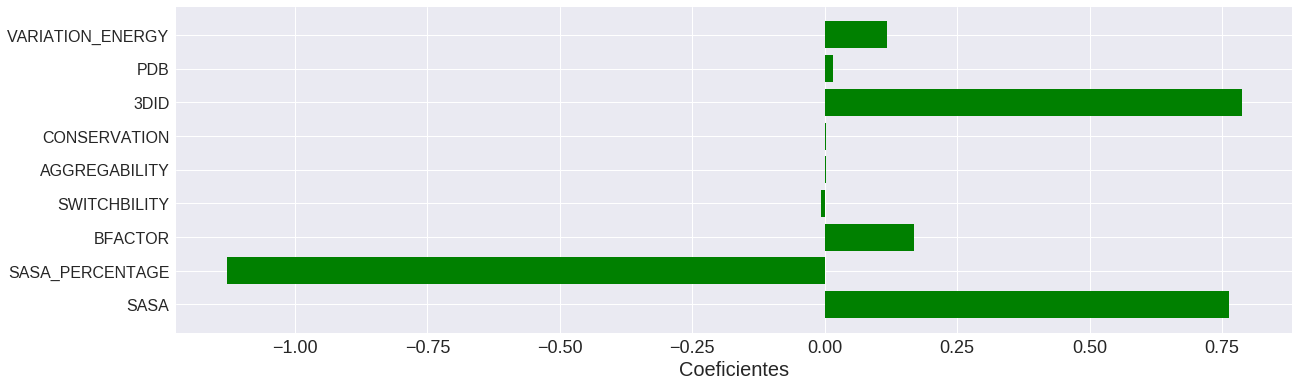

In [142]:
figsize(20,6)
# plt.title("Logistic Regression Coefficients", fontsize=16)
plt.barh(np.arange(len(importances)), [y for x, y in importances], color="g", align="center")
plt.xlabel("Coeficientes", fontsize=20)
plt.xticks(fontsize=18)
plt.yticks(range(len(importances)), [x for x, y in importances], rotation='horizontal', fontsize=16)
# plt.xticks(np.arange(-1.1,.7,.05))
plt.show()

#### SVM

In [25]:
folds = 3
skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=1001)
algorithm = 'svc'
model = Pipeline(model_dict[algorithm]['pipe'])
param_list = [model_dict[algorithm]['params']][0]
gs = GridSearchCV(model, param_list, cv=skf.split(X_train, y_train), n_jobs=2, 
                  scoring='roc_auc', verbose=1, refit=True)

In [26]:
X_test.shape

(2448, 9)

In [27]:
pd.Series(y_test).value_counts()

1    1774
0     674
dtype: int64

In [28]:
gs.fit(X_train, y_train)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   18.8s
[Parallel(n_jobs=2)]: Done  96 out of  96 | elapsed:   49.4s finished


GridSearchCV(cv=<generator object _BaseKFold.split at 0x7f00ab343f10>,
       error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', 'VARIATION_ENERGY'],
      dtype='object'))), ('imputer...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]),
       fit_params=None, iid=True, n_jobs=2,
       param_grid=[{'svc__kernel': ['rbf'], 'svc__gamma': [0.01, 0.001, 0.0001, 1e-05], 'svc__C': [0.001, 0.1, 0.1, 10, 25, 50, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [29]:
svc = gs.best_estimator_

In [30]:
gs.best_score_

0.6992159446523492

In [31]:
model

Pipeline(memory=None,
     steps=[('union', FeatureUnion(n_jobs=1,
       transformer_list=[('continuous', Pipeline(memory=None,
     steps=[('selector', ItemSelector(key=Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', 'VARIATION_ENERGY'],
      dtype='object'))), ('imputer...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [32]:
X_train.columns

Index(['SASA', 'SASA_PERCENTAGE', 'BFACTOR', 'SWITCHBILITY', 'AGGREGABILITY',
       'CONSERVATION', '3DID', 'PDB', 'VARIATION_ENERGY'],
      dtype='object')

In [33]:
print(classification_report(y_test, rf.predict(X_test)))

             precision    recall  f1-score   support

          0       0.57      0.26      0.36       674
          1       0.77      0.93      0.84      1774

avg / total       0.71      0.74      0.71      2448



In [34]:
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

In [35]:
fpr.shape

(852,)

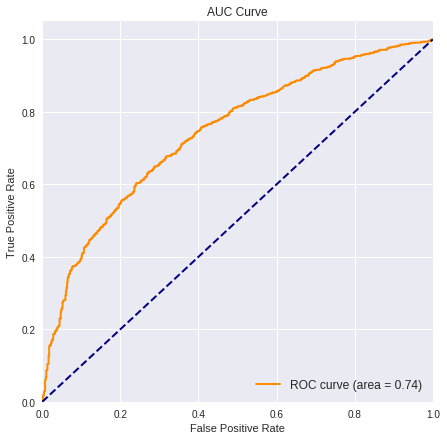

In [36]:
figsize(7,7)

lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUC Curve')
plt.legend(loc="lower right", prop={'size': 12})

plt.savefig("../documents/latex/figures/3/auc_varq.pdf", bbox_inches='tight', pad_inches=0.1)

## Algorithm Comparison

In [58]:
algos = ["LR", "RF", "SVC"]
aucs = [0.71, 0.74, 0.70]

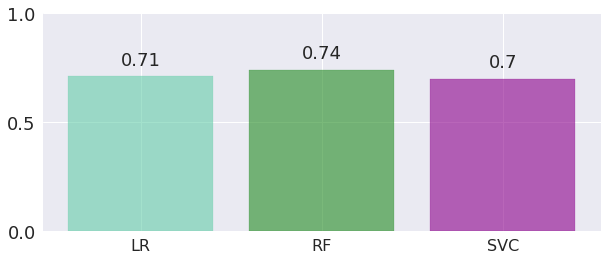

In [114]:
plt.rcParams["font.family"] = "DejaVu Sans"

plt.figure(figsize=(10, 4))

barlist = plt.bar(algos, aucs, alpha=0.6)
barlist[0].set_color('mediumaquamarine')
barlist[1].set_color('forestgreen')
barlist[2].set_color('darkmagenta')

for i, rect in enumerate(barlist):
    height = rect.get_height()
    plt.gca().text(rect.get_x() + rect.get_width()/2., 1.05*height, aucs[i], ha='center', va='bottom', fontsize=18)


plt.xticks(fontsize=16)
plt.yticks(np.arange(0,1.1, 0.5), fontsize=18)

# plt.show()
# plt.legend(["AUC"], fontsize=16)

plt.savefig("varq_results.pdf", bbox_inches='tight', pad_inches=0.1)